# Import important libraries : 

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import numpy as np
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_path = '_static/playback-thumbnail.png'

import librosa

import librosa.display

# We'll need IPython.display's Audio widget
from IPython.display import Audio

# We'll also use `mir_eval` to synthesize a signal for us
# import pyyaml module
import yaml
from yaml.loader import SafeLoader
from tensorflow.keras.utils import to_categorical
import os

import tensorflow as tf
import tensorflow_hub as hub

In [39]:
print(tf.__version__)

2.9.3


In [ ]:
#pip install "tensorflow<2.10"

# Loading Wav2Vec Configuration : 

In [ ]:
! pip3 install -q git+https://github.com/vasudevgupta7/gsoc-wav2vec2@main

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 10.7 MB/s eta 0:00:00


In [40]:
from wav2vec2 import Wav2Vec2Config
config = Wav2Vec2Config()

# Kaggle Session and Downloading Data : 

In [42]:
from google.colab import files
files.upload()
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download salahbarakat/must-c-fbk-ict-en-ar
! unzip must-c-fbk-ict-en-ar

# Transformer Code : 

In [43]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [44]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [45]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [46]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [47]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [48]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [49]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [50]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [51]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

# Loading Data From Files : 

In [52]:
waves_pathes = []
arabic_text_path = None
english_text_path = None
yaml_file_path = None
import os
for dirname, _, filenames in os.walk('/content/dev'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:] == "wav":
            waves_pathes.append(os.path.join(dirname, filename))
            print("waves,Done")
        elif os.path.join(dirname, filename)[-3:] == ".ar":
            arabic_text_path = os.path.join(dirname, filename)
        elif os.path.join(dirname, filename)[-3:] == ".en":
            english_text_path = os.path.join(dirname, filename)
        elif os.path.join(dirname,filename)[-3:] == "aml":
            yaml_file_path = os.path.join(dirname,filename)

print(arabic_text_path)
print(english_text_path)
print(yaml_file_path)
waves_pathes.sort()

waves,Done
waves,Done
waves,Done
waves,Done
waves,Done
waves,Done
waves,Done
waves,Done
waves,Done
waves,Done
waves,Done
/content/dev/txt/dev.ar
/content/dev/txt/dev.en
/content/dev/txt/dev.yaml


In [53]:
file_ar_text = open(arabic_text_path, "r")
file_en_text = open(english_text_path,"r")
all_ar_text = file_ar_text.read()
all_en_text = file_en_text.read()
file_ar_text.close()
file_en_text.close()
print("Length of Arabic text : ",len(all_ar_text))  # Note it is one string
print("Length of English text : ",len(all_en_text)) # Note it is one string 

Length of Arabic text :  119673
Length of English text :  134348


In [54]:
# Split text into sentences
all_en_sentences = all_en_text.split("\n")
all_ar_sentences = all_ar_text.split("\n")

# we pop last position because it has ''
all_ar_sentences.pop()
all_en_sentences.pop()

# check by printing  
print(all_en_sentences[:2])
print(all_ar_sentences[:2])
print("Num of en sentences : ",len(all_en_sentences))
print("Num of ar sentences : ",len(all_ar_sentences))

["I'm going to talk today about energy and climate.", 'And that might seem a bit surprising, because my full-time work at the foundation is mostly about vaccines and seeds, about the things that we need to invent and deliver to help the poorest two billion live better lives.']
['سأحدثكم اليوم حول الطاقة والمناخ.', 'وهذا قد يبدو مفاجئ قليلا لأن عملي بدوام كامل في المؤسسة هو في الغالب في التطعيمات والبذور, حول الأشياء التي نحتاجها للابتكار ونقدمها لمساعدة الاثنين مليار شخص الأشد فقرا ليعيشوا حياة أفضل.']
Num of en sentences :  1073
Num of ar sentences :  1073


In [55]:
# open Yamel File : 
# Open the file and load the file
with open(yaml_file_path) as f:
    data = yaml.load(f, Loader=SafeLoader)
    print(data[0])

# Loading waves corresponding to sentences
MAIN_FILE_PATH = '/content/dev/wav/'
waves = []
for i in range(len(data)):
    waves.append(librosa.load(os.path.join(MAIN_FILE_PATH,data[i]['wav']),sr=16000,offset=data[i]['offset'],duration=data[i]['duration'])[0].astype(float))

{'duration': 3.509999, 'offset': 12.75, 'speaker_id': 'spk.767', 'wav': 'ted_767.wav'}


In [56]:
waves[:2]

[array([-0.01370239,  0.00222778,  0.01116943, ...,  0.00030518,
         0.00067139,  0.00061035]),
 array([ 9.15527344e-05,  2.44140625e-04,  3.05175781e-04, ...,
        -2.41088867e-03, -2.89916992e-03, -2.92968750e-03])]

# Initializing the waves before entering it to the model :

In [57]:
# pop all waves that under 246,000 sample rate : 
size = len(waves)
counter = 0
while counter < size :
    if len(waves[counter])>246000:
        waves.pop(counter)
        all_ar_sentences.pop(counter)
        all_en_sentences.pop(counter)
        counter-=1
        size-=1
    counter+=1

# check lists : 
print("len of ar list : ", len(all_ar_sentences))
print("len of en list : ", len(all_en_sentences))
print("len of waves list : ", len(waves))

len of ar list :  936
len of en list :  936
len of waves list :  936


In [58]:
# pad waves to make all waves have fixed length (246,000) : 
padded_waves = []
for i in waves:
  padded_waves.append(np.pad(i,(0,246000-len(i))))

# Initializing the text before entering it to the model : 



In [59]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# make dictionary : 
tokenizer = Tokenizer(num_words = 2500,oov_token = "<OOV>")
tokenizer.fit_on_texts(all_en_sentences)
word_index = tokenizer.word_index

# makes en sequences : 
en_sequences = tokenizer.texts_to_sequences(all_en_sentences)

# make padding : 
padded_en = pad_sequences(en_sequences,padding = 'post',maxlen=100)

# check : 
print("en dic : ",word_index)

print("len of en dic : ",len(word_index))

print("Sequences : ",en_sequences[:1])

print("padding : ",padded_en[:1])

en dic :  {'<OOV>': 1, 'the': 2, 'and': 3, 'to': 4, 'of': 5, 'a': 6, 'that': 7, 'we': 8, 'you': 9, 'is': 10, 'i': 11, 'in': 12, 'it': 13, 'this': 14, 'so': 15, 'are': 16, 'have': 17, "it's": 18, 'they': 19, 'for': 20, 'can': 21, 'about': 22, 'what': 23, 'but': 24, 'at': 25, 'on': 26, 'do': 27, 'not': 28, 'people': 29, '—': 30, 'now': 31, 'there': 32, 'with': 33, 'as': 34, 'be': 35, 'if': 36, 'get': 37, 'one': 38, 'know': 39, 'an': 40, "that's": 41, 'all': 42, 'was': 43, 'going': 44, 'world': 45, "don't": 46, 'just': 47, 'these': 48, 'very': 49, 'because': 50, 'like': 51, 'my': 52, 'out': 53, 'think': 54, 'up': 55, 'go': 56, 'really': 57, 'actually': 58, 'by': 59, 'how': 60, 'here': 61, 'time': 62, 'more': 63, 'will': 64, "we're": 65, 'games': 66, 'than': 67, 'from': 68, 'then': 69, 'right': 70, 'self': 71, 'would': 72, 'some': 73, 'when': 74, 'something': 75, 'well': 76, 'years': 77, 'them': 78, "i'm": 79, 'has': 80, 'want': 81, 'our': 82, 'no': 83, 'us': 84, 'need': 85, 'thing': 86, '

In [60]:
# make dictionary : 
tokenizer2 = Tokenizer(num_words = 2500,oov_token = "<OOV>")
tokenizer2.fit_on_texts(all_ar_sentences)
word_index2 = tokenizer2.word_index

# makes en sequences : 
ar_sequences = tokenizer2.texts_to_sequences(all_ar_sentences)

# make padding : 
padded_ar = pad_sequences(ar_sequences,padding = 'post',maxlen=100)

# check : 
print("ar dic : ",word_index2)

print("len of ar dic : ",len(word_index2))

print("Sequences : ",ar_sequences[:1])

print("padding : ",padded_ar[:1])

ar dic :  {'<OOV>': 1, 'في': 2, 'من': 3, 'أن': 4, 'على': 5, 'هذا': 6, 'ذلك': 7, 'ما': 8, 'لا': 9, 'هذه': 10, 'إلى': 11, 'هو': 12, 'التي': 13, 'إذا': 14, 'عن': 15, 'الآن': 16, 'هناك': 17, 'كل': 18, 'الذي': 19, 'هنا': 20, 'الناس': 21, 'أنه': 22, 'هي': 23, 'أنا': 24, 'لذا': 25, 'جدا': 26, 'ليس': 27, 'نحن': 28, 'أنها': 29, 'حول': 30, 'مع': 31, 'تلك': 32, 'لم': 33, 'أكثر': 34, 'العالم': 35, 'لكن': 36, 'قد': 37, 'كان': 38, 'شئ': 39, 'لقد': 40, 'أي': 41, 'حسنا': 42, 'كما': 43, 'فقط': 44, 'ضحك': 45, 'الألعاب': 46, 'أو': 47, 'عندما': 48, 'الواقع': 49, 'بعض': 50, 'لدينا': 51, 'ولكن': 52, 'ينبغي': 53, 'نفسية': 54, 'هل': 55, 'التجربة': 56, 'كانت': 57, 'شيء': 58, 'لأن': 59, 'الأشياء': 60, 'للغاية': 61, 'حتى': 62, 'كيف': 63, 'الطاقة': 64, 'أننا': 65, 'وقد': 66, 'اليوم': 67, 'شخص': 68, 'الكثير': 69, 'واحد': 70, 'حيث': 71, 'مثل': 72, 'بها': 73, 'بعد': 74, 'أفضل': 75, 'سيكون': 76, 'ثم': 77, 'كنت': 78, 'بين': 79, 'شكرا': 80, 'نستطيع': 81, 'إنها': 82, 'بأن': 83, 'قبل': 84, 'تكون': 85, 'ليست': 86, 'وهذا':

# Building architecture of the model : 

- Loading pretrained layer of Wav2Vec : 

In [61]:
pretrained_layer = hub.KerasLayer("https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=False)

In [70]:
# Determinate important paramaters :  
AUDIO_MAXLEN = 246000
vocab_size = 2500
embedding_dim = 64
max_length = 100

In [71]:
# Wav2Vec layers : 
wav_inputs = tf.keras.Input(shape=(AUDIO_MAXLEN),name="wave2vec_inputs")
hidden_states = pretrained_layer(wav_inputs)
outputs1 = tf.keras.layers.Dense(config.vocab_size,name="wav2vec2_output")(hidden_states)

In [72]:
# CNN layers :
outputs1 = layers.Conv1D(filters= 512,kernel_size=5,strides=4,activation="relu")(outputs1)
outputs1 = layers.Conv1D(filters= 512,kernel_size=5,strides=4,activation="relu")(outputs1)

In [73]:
# 6 Encoder layers : 
encoder_layer1 = EncoderLayer(d_model=512, num_heads=8, dff=2048)
encoder_layer2 = EncoderLayer(d_model=512, num_heads=8, dff=2048)
encoder_layer3 = EncoderLayer(d_model=512, num_heads=8, dff=2048)
encoder_layer4 = EncoderLayer(d_model=512, num_heads=8, dff=2048)
encoder_layer5 = EncoderLayer(d_model=512, num_heads=8, dff=2048)
encoder_layer6 = EncoderLayer(d_model=512, num_heads=8, dff=2048)

# Applying them : 
outputs1 = encoder_layer1(outputs1)
outputs2 = encoder_layer2(outputs1)
outputs3 = encoder_layer3(outputs2)
outputs4 = encoder_layer4(outputs3)
outputs5 = encoder_layer5(outputs4)
outputs6 = encoder_layer6(outputs5)

In [74]:
#ar Text input and embedding : 
ar_text_inputs = tf.keras.Input(shape=(None,) , name= "Text_inputs_ar")
ar_text_features = layers.Embedding(vocab_size, embedding_dim,input_length=max_length)(ar_text_inputs)

In [75]:
#en Text input and embedding : 
en_text_inputs = tf.keras.Input(shape=(None,) , name= "Text_inputs_en")
en_text_features = layers.Embedding(vocab_size, embedding_dim)(en_text_inputs)

In [76]:
# 6 Decoder layers :
decoder_layer1 = DecoderLayer(d_model=512, num_heads=8, dff=2048)
decoder_layer2 = DecoderLayer(d_model=512, num_heads=8, dff=2048)
decoder_layer3 = DecoderLayer(d_model=512, num_heads=8, dff=2048)
decoder_layer4 = DecoderLayer(d_model=512, num_heads=8, dff=2048)
decoder_layer5 = DecoderLayer(d_model=512, num_heads=8, dff=2048)
decoder_layer6 = DecoderLayer(d_model=512, num_heads=8, dff=2048)

# Applying them for Arabic :
ar1 = decoder_layer1(x=outputs1, context=ar_text_features)
ar2 = decoder_layer2(x=ar1, context=outputs6)
ar3 = decoder_layer3(x=ar2, context=outputs6)
ar4 = decoder_layer4(x=ar3, context=outputs6)
ar5 = decoder_layer5(x=ar4, context=outputs6)
ar6 = decoder_layer6(x=ar5, context=outputs6)

# Applying them for English : 
en1 = decoder_layer1(x=outputs1, context=en_text_features)
en2 = decoder_layer2(x=en1, context=outputs6)
en3 = decoder_layer3(x=en2, context=outputs6)
en4 = decoder_layer4(x=en3, context=outputs6)
en5 = decoder_layer5(x=en4, context=outputs6)
en6 = decoder_layer6(x=en5, context=outputs6)

In [77]:
from keras.layers.serialization import activation
# Fully Connected for English :
en6 = layers.Flatten()(en6)
en6 = layers.Dense(512,activation="relu",)(en6)
en6 = layers.Dropout(0.3)(en6)
en6 = layers.Dense(100,activation="sigmoid")(en6)

In [78]:
# Fully Connected for Arabic : 
ar6 = layers.Flatten()(ar6)
ar6 = layers.Dense(512,activation="relu",)(ar6)
ar6 = layers.Dropout(0.3)(ar6)
ar6 = layers.Dense(100,activation="sigmoid")(ar6)

In [79]:
# Put all layers together : 
model = tf.keras.Model(inputs=[wav_inputs,ar_text_inputs,en_text_inputs], outputs=[ar6,en6],name = "wav2vec_model")

In [80]:
# Compile the model : 
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss= tf.keras.losses.MeanSquaredError(),
)

# Display Model graph and Summary :  

In [ ]:
#model.summary()

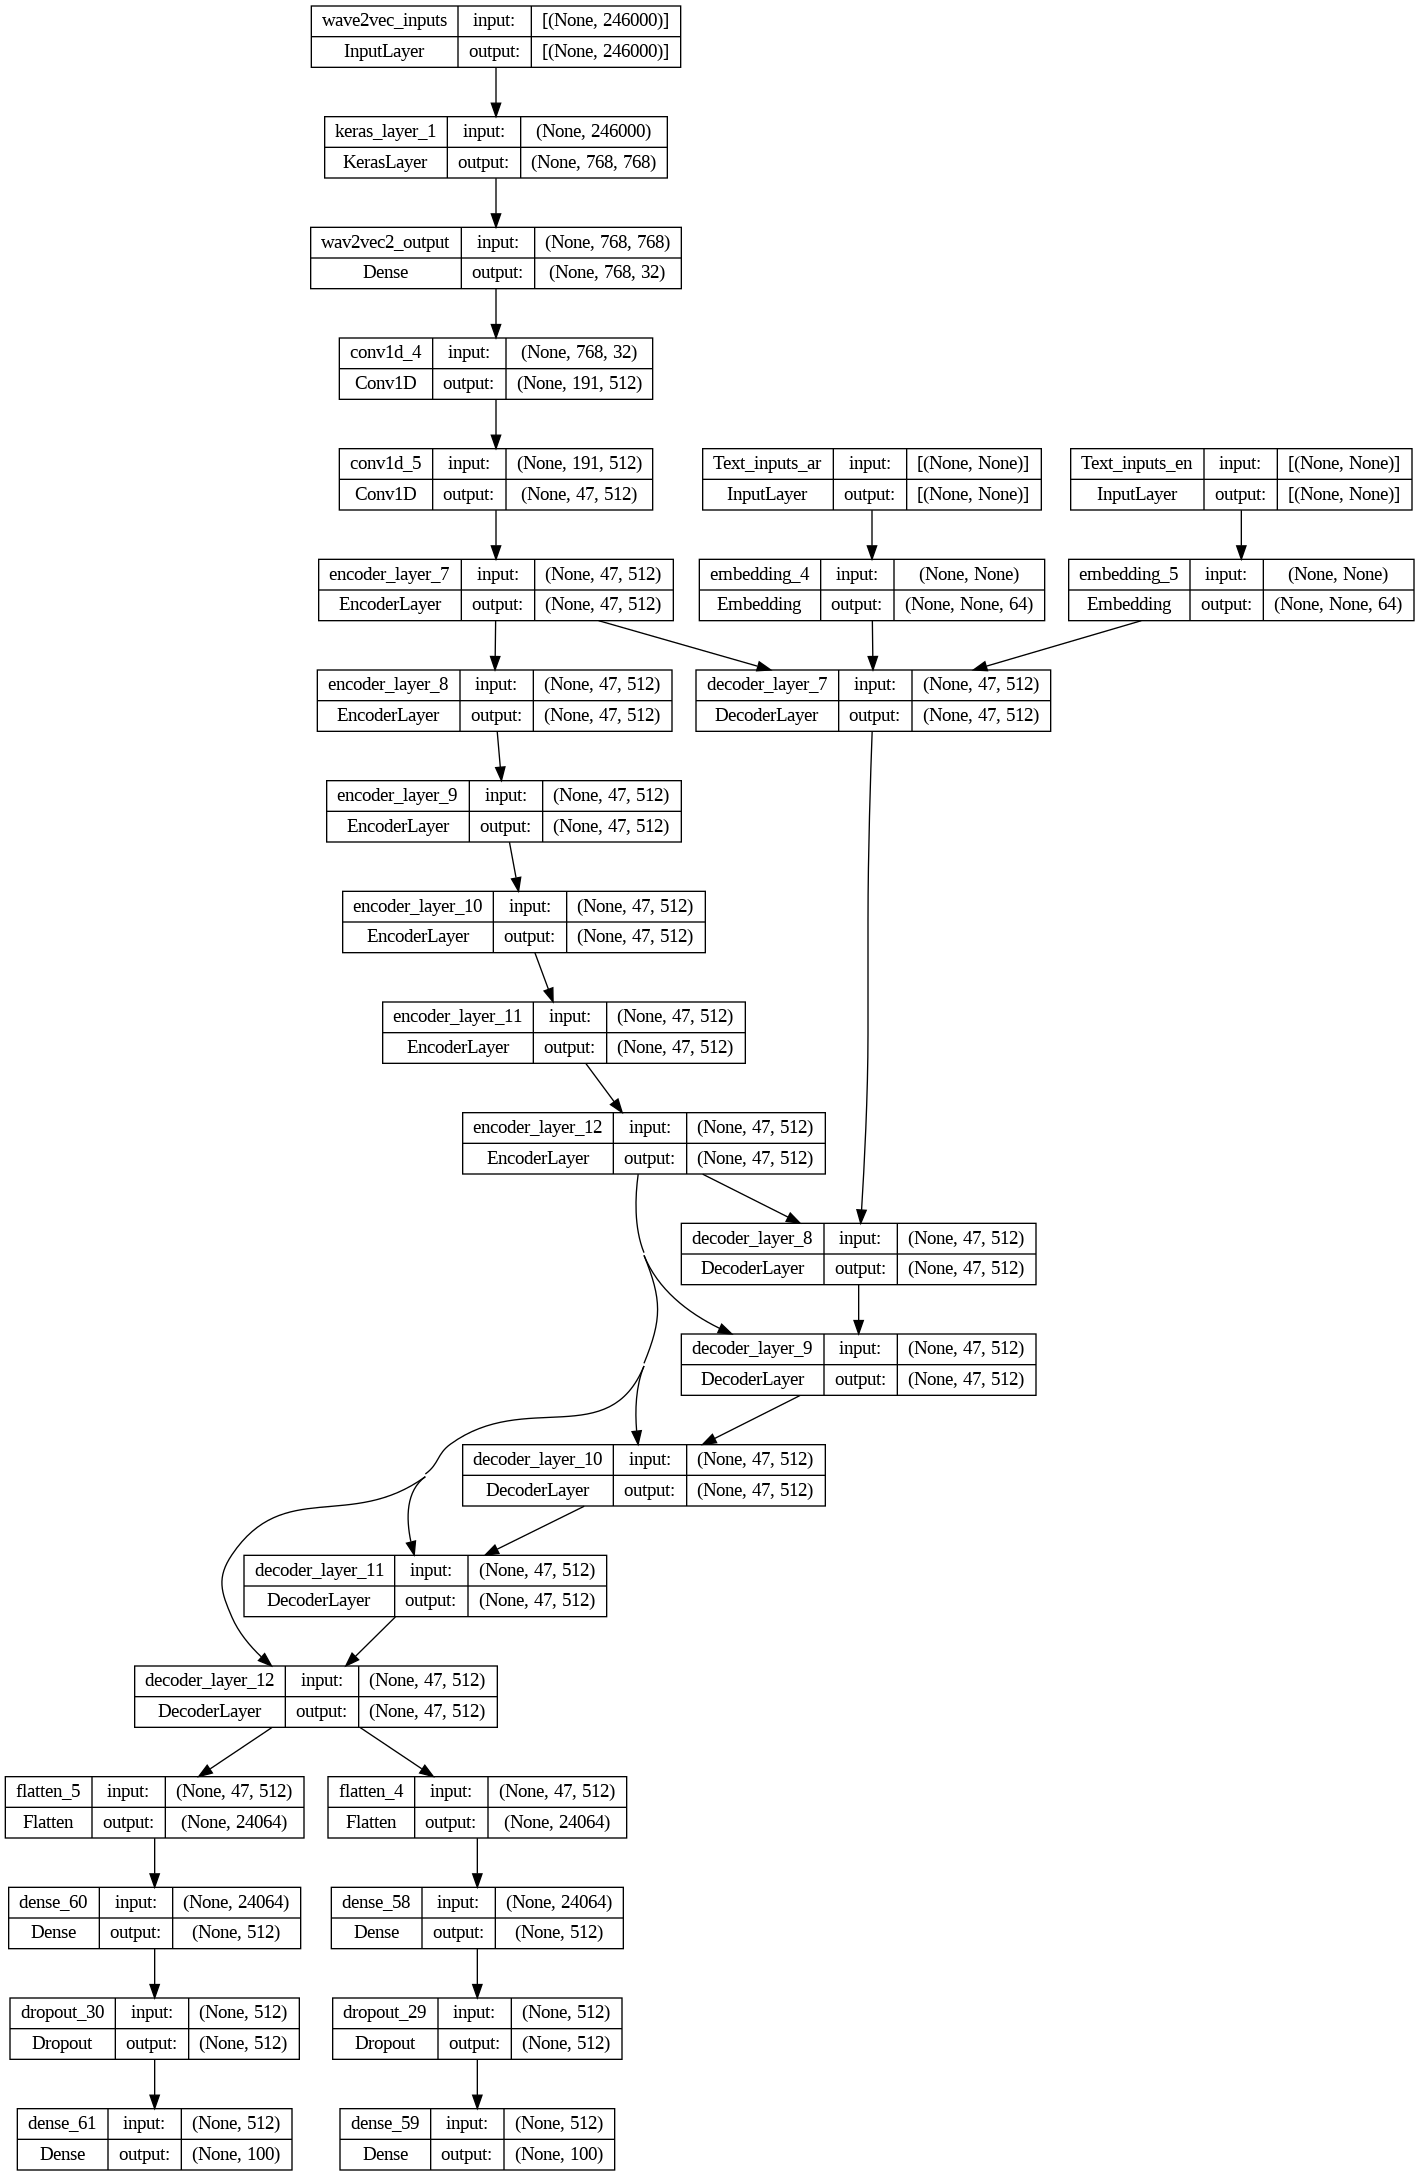

In [81]:
keras.utils.plot_model(model,show_shapes=True)

# Trainig Model : 

In [82]:
# model.fit(x=[np.array(padded_waves[:5]),np.array(padded_ar[:5]),np.array(padded_en[:5])],y=[np.array(padded_ar[:5]),np.array(padded_en[:5])],epochs=1,verbose=1)